In [3]:
from env_two_step import Scenario, AMoD
from MPC import MPC
import os
from util import mat2str
import subprocess
from collections import defaultdict
from tqdm import trange
import numpy as np

device = 'linux'
if device == 'windows':
    CPLEXPATH = "C:/Program Files/ibm/ILOG/CPLEX_Studio1210/opl/bin/x64_win64/"
elif device == 'mac':
    CPLEXPATH = "/Applications/CPLEX_Studio1210/opl/bin/x86-64_osx/"
elif device == 'linux':
    CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
    
def solveRebFlow(env,res_path,desiredAcc,CPLEXPATH):
    t = env.time
    accRLTuple = [(n,desiredAcc[n]) for n in desiredAcc]
    accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
    edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
    modPath = os.getcwd().replace('\\','/')+'/mod/'
    OPTPath = os.getcwd().replace('\\','/')+'/MPC/'+res_path
    if not os.path.exists(OPTPath):
        os.makedirs(OPTPath)
    datafile = OPTPath + f'data_{t}.dat'
    resfile = OPTPath + f'res_{t}.dat'
    with open(datafile,'w') as file:
        file.write('path="'+resfile+'";\r\n')
        file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
        file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
        file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')
    modfile = modPath+'minRebDistRebOnly.mod'
    if CPLEXPATH is None:
        CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
    my_env = os.environ.copy()
    my_env["LD_LIBRARY_PATH"] = CPLEXPATH
    out_file =  OPTPath + f'out_{t}.dat'
    with open(out_file,'w') as output_f:
        subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
    output_f.close()

    # 3. collect results from file
    flow = defaultdict(float)
    with open(resfile,'r', encoding="utf8") as file:
        for row in file:
            item = row.strip().strip(';').split('=')
            if item[0] == 'flow':
                values = item[1].strip(')]').strip('[(').split(')(')
                for v in values:
                    if len(v) == 0:
                        continue
                    i,j,f = v.split(',')
                    flow[int(i),int(j)] = float(f)
    action = [flow[i,j] for i,j in env.edges]
    return action

### Scenario 1

In [8]:
# three levels
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}, fix_price=True) # uni-directional
env = AMoD(scenario)
mpc = MPC(env, CPLEXPATH)

In [11]:
test_episodes = 100
max_steps = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []
action_list = []

for episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        episode_action_list = []
        obs = env.reset()
        done = False
        while(not done):
            res_path = 'tri-level/'
            desiredAcc = mpc.tri_level() 
            episode_action_list.append(desiredAcc)
            obs, reward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH,PATH=res_path)
            episode_reward += reward 
            rebAction = solveRebFlow(env,'reb_'+res_path,desiredAcc,CPLEXPATH)
            obs, reward, done, info = env.reb_step(rebAction)
            episode_reward += reward
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            episode_revenue += info['revenue']
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
        action_list.append(episode_action_list)
        break
    except KeyboardInterrupt:
        break

Episode 1 | Reward: 3149.80 | Revenue: 3474.00 | ServedDemand: 388.00 | Reb. Cost: 92.60000000000002 | Oper. Cost: 324.20:   0%|          | 0/100 [00:42<?, ?it/s]

In [23]:
rl_actions = [list(list(action_list[0][t].values())/np.sum(list(action_list[0][t].values()))) for t in range(len(action_list[0]))]

In [110]:
# three levels
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}, fix_price=True) # uni-directional
env = AMoD(scenario)
mpc = MPC(env, CPLEXPATH)

In [40]:
test_episodes = 100
max_steps = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []
action_list = []

for episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        episode_action_list = []
        obs = env.reset()
        done = False
        while(not done):
            res_path = 'tri-level/'
            desiredAcc = mpc.tri_level() 
            episode_action_list.append(desiredAcc)
            obs, reward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH,PATH=res_path)
            episode_reward += reward 
            rebAction = solveRebFlow(env,'reb_'+res_path,desiredAcc,CPLEXPATH)
            obs, reward, done, info = env.reb_step(rebAction)
            episode_reward += reward
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            episode_revenue += info['revenue']
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
        action_list.append(episode_action_list)
        break
    except KeyboardInterrupt:
        break




  0%|          | 0/100 [00:00<?, ?it/s]


Episode 1 | Reward: 3149.80 | Revenue: 3474.00 | ServedDemand: 388.00 | Reb. Cost: 92.60000000000002 | Oper. Cost: 324.20:   0%|          | 0/100 [01:02<?, ?it/s]

#### Policy Visualization

In [165]:
import matplotlib.pyplot as plt

In [111]:
_ = env.reset()

In [112]:
cell_demand = [np.sum([env.demand[i, j][t] if i!=j else 0 for j in env.region for t in range(env.tf)]) for i in env.region]

In [113]:
cell_demand

[155, 167, 35, 34, 29, 51, 32, 40]

In [119]:
rl_actions = np.array([list(list(action_list[0][t].values()))/np.sum(list(action_list[0][t].values())) for t in range(len(action_list[0]))])

/home/daga/anaconda3/envs/pyro1/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [171]:
rl_actions_cell = np.zeros((60, 4, 2))
for t in range(60):
    for i in range(1, 5):
        rl_actions_cell[t, i-1,:] = rl_actions[t][2*(i-1):2*i]
rl_actions_cell = np.transpose(rl_actions_cell, axes=[0,2,1])
rl_actions_cell[np.isnan(rl_actions_cell)] = 0.

In [175]:
rl_actions_cell[0]

array([[0.2  , 0.05 , 0.05 , 0.   ],
       [0.425, 0.125, 0.075, 0.075]])

In [205]:
import matplotlib.animation as animation

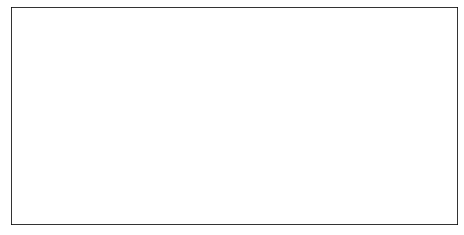

In [297]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.xticks([])
plt.yticks([])

def animate(t):
    plt.title(f"Rebalancing Policy t={t}")
    for txt in ax.texts:
        txt.set_visible(False)
    for i, elem in enumerate(rl_actions_cell[t][0, :]):
        ax.text(1*(i)-0.15, 0., f"{elem:.2f}", size=13, color="white")
    for i, elem in enumerate(rl_actions_cell[t][1, :]):
        ax.text(1*(i)-0.15, 1., f"{elem:.2f}", size=13, color="white")
    ax.imshow(rl_actions_cell[t], cmap="winter")
#     imshow.set_array(rl_actions_cell[t])
    return None

anim = animation.FuncAnimation(fig, animate, frames=30, interval=1000, blit=False, repeat=True)

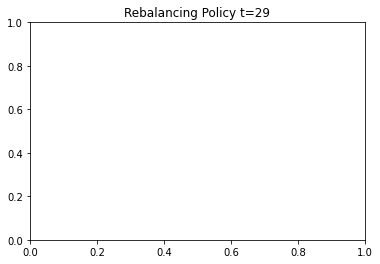

In [298]:
anim.save('mpc_policy_animated.gif', writer='imagemagick')